# 1. Описание данных
Dataset: "Los Angeles Building and Safety Permits" — это набор данных, который содержит информацию о разрешениях на строительство, выданных в городе Лос-Анджелес. Данные включают различные атрибуты, такие как тип разрешения, его описание, дата подачи, адрес, разрешенная площадь, стоимость и другие параметры. Эти данные можно использовать для анализа тенденций в строительстве, выявления аномальных случаев или прогнозирования будущих разрешений.

# 2. Предложение задачи
Задача, которую можно решить на этом наборе данных:
Предсказание вероятности одобрения разрешения или классификация типов разрешений на основе данных о характеристиках разрешений.

К примеру, мы можем решить задачу классификации, где целью будет классификация разрешений на строительство по типу (например, разрешение на жилое, коммерческое или промышленное строительство). Это позволит городским органам лучше планировать распределение ресурсов или следить за соблюдением норм.

# 3. Выбор алгоритма машинного обучения
Для этой задачи хорошо подойдет алгоритм классификации, так как мы имеем категориальную цель — тип разрешения. Можно выбрать следующие алгоритмы:

Логистическая регрессия — для классификации, если признаки линейно разделимы, это простой и интерпретируемый алгоритм.
Случайный лес (Random Forest) — более сложный, но мощный алгоритм, который хорошо работает с категориальными и числовыми признаками. Он также поможет в случае наличия коллинеарности между признаками.
Градиентный бустинг (XGBoost или LightGBM) — эффективные алгоритмы для сложных задач, где важно учитывать взаимодействия между признаками и минимизировать ошибки.
Для начала можно попробовать все три метода, чтобы увидеть, какой из них дает наилучший результат.

# 4. Методы оценивания эффективности алгоритма
Для оценки эффективности работы алгоритма будем использовать следующие методы:

Точность (Accuracy) — процент правильно предсказанных классов.
Матрица ошибок (Confusion Matrix) — для более детального анализа, сколько классов было предсказано неправильно.
F1-score — баланс между точностью и полнотой, полезен для случаев с несбалансированными классами.
ROC AUC — для оценки качества классификации в условиях дисбаланса классов.

# 5. Решение
**1. Загрузка и первоначальный анализ данных**

In [26]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("cityofLA/los-angeles-building-and-safety-permits")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11


In [27]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11"

# список файлов
print(os.listdir(dataset_path))


['building-and-safety-permit-information.csv', 'socrata_metadata_building-and-safety-temporary-special-event-tse-permits.json', 'building-and-safety-temporary-special-event-tse-permits.csv', 'socrata_metadata_building-and-safety-permit-information.json']


In [28]:
!mkdir -p /content/dataset
!cp -r /root/.cache/kagglehub/datasets/cityofLA/los-angeles-building-and-safety-permits/versions/11/* /content/dataset/

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from xgboost import XGBClassifier

In [30]:
# Загрузка данных
dataset_path = "/content/dataset/building-and-safety-permit-information.csv"
df = pd.read_csv(dataset_path)

<ipython-input-30-71f5a810eaac>:3: DtypeWarning: Columns (1,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(dataset_path)


In [31]:
# Настройка параметров для полного отображения столбцов и без ограничения ширины
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

first_five_rows = df.head()
display(first_five_rows)

,Assessor Book,Assessor Page,Assessor Parcel,Tract,Block,Lot,Reference # (Old Permit #),PCIS Permit #,Status,Status Date,Permit Type,Permit Sub-Type,Permit Category,Project Number,Event Code,Initiating Office,Issue Date,Address Start,Address Fraction Start,Address End,Address Fraction End,Street Direction,Street Name,Street Suffix,Suffix Direction,Unit Range Start,Unit Range End,Zip Code,Work Description,Valuation,Floor Area-L.A. Zoning Code Definition,# of Residential Dwelling Units,# of Accessory Dwelling Units,# of Stories,Contractor's Business Name,Contractor Address,Contractor City,Contractor State,License Type,License #,Principal First Name,Principal Middle Name,Principal Last Name,License Expiration Date,Applicant First Name,Applicant Last Name,Applicant Business Name,Applicant Address 1,Applicant Address 2,Applicant Address 3,Zone,Occupancy,Floor Area-L.A. Building Code Definition,Census Tract,Council District,Latitude/Longitude,Applicant Relationship,Existing Code,Proposed Code,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified)
0,4317.0,3.0,***,TR 30210-C,NaN,LT 1,NaN,15044-90000-08405,Permit Finaled,2015-09-10T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2015-08-18T00:00:00.000,1823.0,1/2,1823.0,1/2,S,THAYER,AVE,NaN,NaN,NaN,90025.0,NaN,NaN,NaN,NaN,NaN,NaN,CONDITIONED AIRE MECHANICAL & ENGINEERING INC,18650 PARTHENIA STREET,NORTHRIDGE,CA,C20,532440.0,BRETT,MOORE,HOFFER,2016-06-30T00:00:00.000,BRETT,HOFFER,NaN,18650 PARTHENIA ST,NaN,"NORTHRIDGE, CA",R3-1-O,NaN,0.0,2671.00,5.0,"{'longitude': '-118.42628', 'human_address': '...",Net Applicant,NaN,NaN,23443.0,859.0,738.0,9.0,6.0,75.0
1,5005.0,10.0,017,CHESTERFIELD SQUARE,NaN,465,16SL57806,16016-70000-02464,Permit Finaled,2017-08-01T00:00:00.000,Bldg-Alter/Repair,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,SOUTH LA,2016-02-04T00:00:00.000,2122.0,NaN,2122.0,NaN,W,54TH,ST,NaN,NaN,NaN,90062.0,General rehabilitation for single family dwell...,40000.0,NaN,NaN,NaN,NaN,OWNER-BUILDER,NaN,NaN,NaN,NaN,0.0,JAVIER,NaN,TALAMANTES,NaN,JAVIER,TALAMANTES,OWNER-BUILDER,NaN,NaN,NaN,C2-1VL,NaN,NaN,2325.00,8.0,"{'longitude': '-118.31668', 'human_address': '...",Owner-Bldr,1.0,NaN,24027.0,743.0,622.0,7.0,14.0,35.0
2,5154.0,23.0,022,SUN-SET TRACT,D,13,14VN81535,14016-20000-13092,Issued,2014-08-13T00:00:00.000,Bldg-Alter/Repair,Apartment,Plan Check,NaN,NaN,VAN NUYS,2014-08-13T00:00:00.000,415.0,NaN,415.0,NaN,S,BURLINGTON,AVE,NaN,1-30,1-30,90057.0,PHOTOVOLTAIC SOLAR PANELS ON ROOF OF (E) APT BLDG,37000.0,NaN,NaN,NaN,NaN,PERMACITY CONSTRUCTION CORP,5570 W WASHINGTON BLVD,LOS ANGELES,CA,B,827864.0,JONATHAN,SAUL,PORT,2015-11-30T00:00:00.000,LINDA,MARTON,NaN,710 WILSHIRE BLVD,NaN,"SANTA MONICA, CA",R4-1,NaN,NaN,2089.04,1.0,"{'longitude': '-118.26997', 'human_address': '...",Agent for Owner,5.0,NaN,24352.0,563.0,836.0,NaN,11.0,67.0
3,4404.0,30.0,010,TR 12086,NaN,2,NaN,16044-30000-09658,Permit Finaled,2016-08-29T00:00:00.000,HVAC,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,WEST LA,2016-08-22T00:00:00.000,315.0,NaN,315.0,NaN,S,OCEANO,DR,NaN,NaN,NaN,90049.0,NaN,NaN,NaN,NaN,NaN,NaN,E/C HEATING AND AIR CONDITION,26888 CUATRO MILPAS ST,VALENCIA,CA,C20,651051.0,EDY,RUDOLFO,CORDON,2018-07-31T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,RS-1,NaN,0.0,2640.00,11.0,"{'longitude': '-118.4732', 'human_address': '{...",Contractor,NaN,NaN,23680.0,840.0,1219.0,9.0,10.0,NaN
4,2646.0,19.0,011,TR 7158,NaN,11,NaN,17042-90000-31792,Permit Finaled,2017-12-28T00:00:00.000,Plumbing,1 or 2 Family Dwelling,No Plan Check,NaN,NaN,INTERNET,2017-12-26T00:00:00.000,13640.0,NaN,13640.0,NaN,W,PIERCE,ST,NaN,NaN,NaN,91331.0,NaN,NaN,NaN,NaN,NaN,NaN,TITANIUM POWER INC,1545 S LA CIENEGA BLVD,LOS ANGELES,CA,B,989217.0,DENNIS,HARUO,MIYAHIRA,2017-12-31T00:00:00.000,YONI,GHERMEZI,NaN,1545 S LA CIENEGA BLVD,NaN,"LOS ANGELES, CA",R1-1-O,NaN,0.0,1044.03,7.0,"{'longitude': '-118.43002', 'human_address': '...",Net Applicant,NaN,NaN,18907.0,26.0,408.0,NaN,1.0,11.0


In [32]:
# Вывод информации о датасете: типы данных и количество ненулевых значений
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082006 entries, 0 to 1082005
Data columns (total 65 columns):
 #   Column                                    Non-Null Count    Dtype  
---  ------                                    --------------    -----  
 0   Assessor Book                             1080796 non-null  float64
 1   Assessor Page                             1080796 non-null  object 
 2   Assessor Parcel                           1080796 non-null  object 
 3   Tract                                     1077477 non-null  object 
 4   Block                                     210541 non-null   object 
 5   Lot                                       1074314 non-null  object 
 6   Reference # (Old Permit #)                481448 non-null   object 
 7   PCIS Permit #                             1082006 non-null  object 
 8   Status                                    1082006 non-null  object 
 9   Status Date                               1082006 non-null  object 
 10  Permit

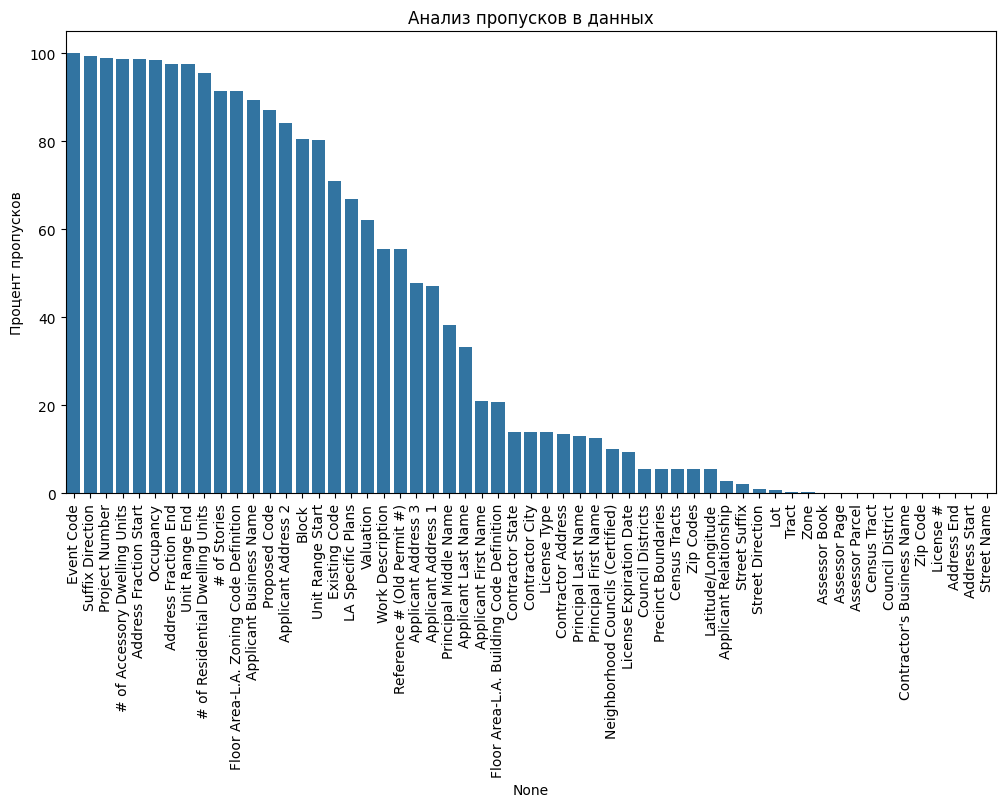

In [33]:
# Анализ пропусков
missing_values = df.isnull().sum() / len(df) * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.ylabel("Процент пропусков")
plt.title("Анализ пропусков в данных")
plt.show()

# Обработка целевой переменной


Permit Type
Electrical              309689
Bldg-Alter/Repair       250025
Plumbing                204465
HVAC                    106238
Fire Sprinkler           41781
Bldg-Addition            38918
Bldg-New                 26404
Grading                  21630
Nonbldg-New              18783
Swimming-Pool/Spa        14512
Bldg-Demolition          14434
Sign                     13712
Elevator                 13679
Nonbldg-Alter/Repair      5457
Pressure Vessel           1987
Nonbldg-Addition           215
Nonbldg-Demolition          69
Bldg-Relocation              8
Name: count, dtype: int64


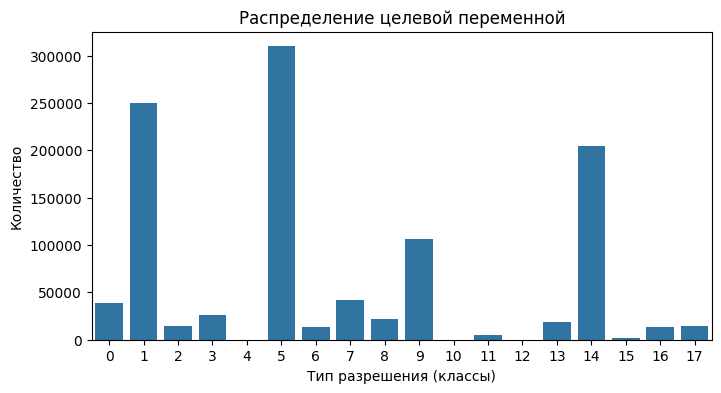

In [34]:
print(df["Permit Type"].value_counts())

# Преобразование целевой переменной
label_encoder = LabelEncoder()
df["Permit Type"] = label_encoder.fit_transform(df["Permit Type"])

# Проверка дисбаланса классов
plt.figure(figsize=(8, 4))
sns.countplot(x=df["Permit Type"])
plt.xlabel("Тип разрешения (классы)")
plt.ylabel("Количество")
plt.title("Распределение целевой переменной")
plt.show()

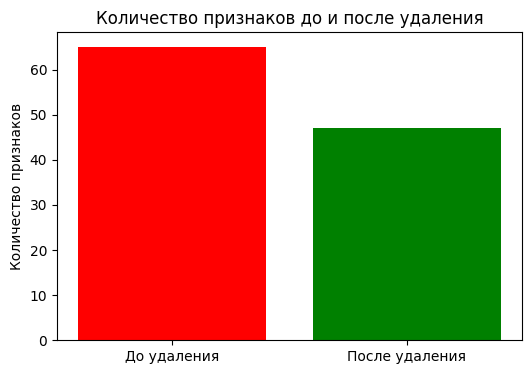


Удалено 18 признаков:
['Event Code', 'Suffix Direction', 'Project Number', '# of Accessory Dwelling Units', 'Address Fraction Start', 'Occupancy', 'Address Fraction End', 'Unit Range End', '# of Residential Dwelling Units', '# of Stories', 'Floor Area-L.A. Zoning Code Definition', 'Applicant Business Name', 'Proposed Code', 'Applicant Address 2', 'Block', 'Unit Range Start', 'PCIS Permit #', 'Reference # (Old Permit #)']


In [35]:
# Количество признаков до удаления
initial_columns = df.shape[1]

# Удаляем ID и признаки с пропусками > 80%
threshold = 80  # Порог отсечения
cols_to_drop = missing_values[missing_values > threshold].index.tolist()
cols_to_drop.extend(["PCIS Permit #", "Reference # (Old Permit #)"])
df.drop(columns=cols_to_drop, inplace=True)

# Количество признаков после удаления
final_columns = df.shape[1]

# График количества удаленных признаков
plt.figure(figsize=(6, 4))
plt.bar(["До удаления", "После удаления"], [initial_columns, final_columns], color=["red", "green"])
plt.ylabel("Количество признаков")
plt.title("Количество признаков до и после удаления")
plt.show()

# Вывод списка удаленных признаков
print(f"\nУдалено {initial_columns - final_columns} признаков:")
print(cols_to_drop)


**2. Обработка целевой переменной**

*   Создание бинарного таргета
*   Анализ дисбаланса классов



**3. Удаление нефункциональных признаков**

*   Столбцы с высоким % пропусков (>80%)
*   Уникальные идентификаторы (например, Permit #)


**4. Обработка пропусков**

*   Числовые признаки: Замена медианой.
*   Категориальные признаки: Замена модой.


**5. Преобразование категориальных признаков**

*   One-Hot Encoding для ключевых категорий
*   Label Encoding для бинарных категорий

**6. Обработка аномалий**

*   Удаление строк с нестандартными значениями (например, '*'):


**7. Разделение данных**

*   Выделение признаков и таргета
*   Стратифицированное разбиение

**8. Обучение модели Random Forest**

*   Инициализация модели
*   Обучение модели


**9. Оценка эффективности модели**

*   Базовые метрики
*   ROC-AUC кривая
*   Важность признаков